<a href="https://colab.research.google.com/github/neuromodgames/SelfDrivingCar/blob/main/BehaviouralCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
!git clone https://github.com/neuromodgames/SelfDrivingCar/

fatal: destination path 'SelfDrivingCar' already exists and is not an empty directory.


In [225]:
!ls SelfDrivingCar/Track1/Data

driving_log.csv  IMG


In [226]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [227]:
datadir = 'SelfDrivingCar/Track1/Data/'
columns = ['center', 'left', 'right','steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\NMG\Data\IMG\center_2022_07_20_11_46_27_428.jpg,C:\NMG\Data\IMG\left_2022_07_20_11_46_27_428.jpg,C:\NMG\Data\IMG\right_2022_07_20_11_46_27_428.jpg,0.0,0.0,0,0.000078
1,C:\NMG\Data\IMG\center_2022_07_20_11_46_27_529.jpg,C:\NMG\Data\IMG\left_2022_07_20_11_46_27_529.jpg,C:\NMG\Data\IMG\right_2022_07_20_11_46_27_529.jpg,0.0,0.0,0,0.000079
2,C:\NMG\Data\IMG\center_2022_07_20_11_46_27_635.jpg,C:\NMG\Data\IMG\left_2022_07_20_11_46_27_635.jpg,C:\NMG\Data\IMG\right_2022_07_20_11_46_27_635.jpg,0.0,0.0,0,0.000079
3,C:\NMG\Data\IMG\center_2022_07_20_11_46_27_737.jpg,C:\NMG\Data\IMG\left_2022_07_20_11_46_27_737.jpg,C:\NMG\Data\IMG\right_2022_07_20_11_46_27_737.jpg,0.0,0.0,0,0.000078
4,C:\NMG\Data\IMG\center_2022_07_20_11_46_27_838.jpg,C:\NMG\Data\IMG\left_2022_07_20_11_46_27_838.jpg,C:\NMG\Data\IMG\right_2022_07_20_11_46_27_838.jpg,0.0,0.0,0,0.000078


In [228]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_07_20_11_46_27_428.jpg,left_2022_07_20_11_46_27_428.jpg,right_2022_07_20_11_46_27_428.jpg,0.0,0.0,0,0.000078
1,center_2022_07_20_11_46_27_529.jpg,left_2022_07_20_11_46_27_529.jpg,right_2022_07_20_11_46_27_529.jpg,0.0,0.0,0,0.000079
2,center_2022_07_20_11_46_27_635.jpg,left_2022_07_20_11_46_27_635.jpg,right_2022_07_20_11_46_27_635.jpg,0.0,0.0,0,0.000079
3,center_2022_07_20_11_46_27_737.jpg,left_2022_07_20_11_46_27_737.jpg,right_2022_07_20_11_46_27_737.jpg,0.0,0.0,0,0.000078
4,center_2022_07_20_11_46_27_838.jpg,left_2022_07_20_11_46_27_838.jpg,right_2022_07_20_11_46_27_838.jpg,0.0,0.0,0,0.000078


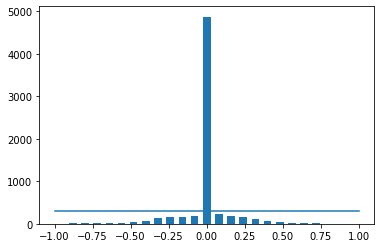

In [229]:
num_bins = 25
samples_per_bin = 300
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6543
removed : 4575
remaining 1968


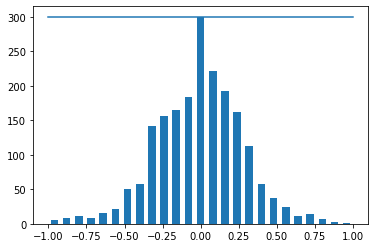

In [230]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed :', len(remove_list))
data.drop(data.index[remove_list], inplace= True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [231]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [232]:
X_train, X_validation, Y_train, Y_validation = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 4444)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_validation)))

Training Samples: 1574
Validation Samples: 394


Text(0.5, 1.0, 'Validation Set')

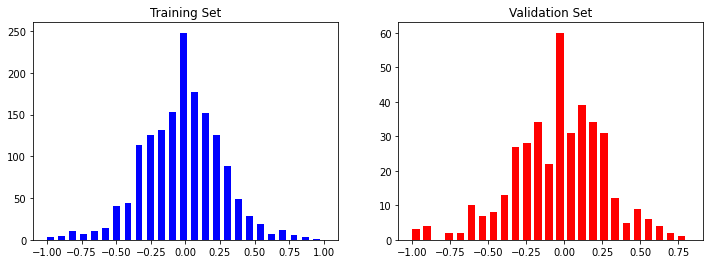

In [233]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(Y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training Set')
axes[1].hist(Y_validation, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation Set')

In [234]:
def img_preprocess(img_path):
  img = mpimg.imread(img_path)
  img = img[60:135, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

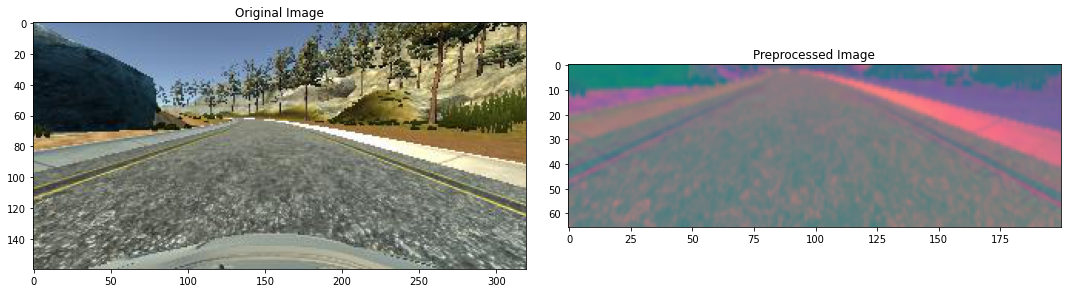

In [235]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axis = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')

In [236]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_validation = np.array(list(map(img_preprocess, X_validation)))

(1574, 66, 200, 3)


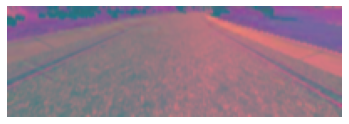

In [237]:
plt.imshow(X_train[random.randint(0,len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [238]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,  kernel_size=(5,5), strides = (2,2), input_shape = (66, 200, 3), activation = 'relu'))
  model.add(Convolution2D(36,  kernel_size=(5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(48,  kernel_size=(5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(64,  kernel_size=(3,3), activation = 'elu'))
  model.add(Convolution2D(64,  kernel_size=(3,3), activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(learning_rate = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)

  return model

In [239]:
model = nvidia_model()
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_57 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_58 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_59 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_29 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_10 (Flatten)        (None, 1152)            

In [240]:
history = model.fit(X_train, Y_train, epochs = 30, validation_data =  (X_validation, Y_validation), batch_size = 100, verbose = 1, shuffle = 1)

Epoch 1/30
16/16 [==============================] - 1s 43ms/step - loss: 0.4965 - val_loss: 0.0931
Epoch 2/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0936 - val_loss: 0.0898
Epoch 3/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0840 - val_loss: 0.0898
Epoch 4/30
16/16 [==============================] - 0s 23ms/step - loss: 0.0810 - val_loss: 0.0873
Epoch 5/30
16/16 [==============================] - 0s 23ms/step - loss: 0.0791 - val_loss: 0.0837
Epoch 6/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0768 - val_loss: 0.0766
Epoch 7/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0714 - val_loss: 0.0716
Epoch 8/30
16/16 [==============================] - 0s 23ms/step - loss: 0.0680 - val_loss: 0.0616
Epoch 9/30
16/16 [==============================] - 0s 23ms/step - loss: 0.0584 - val_loss: 0.0492
Epoch 10/30
16/16 [==============================] - 0s 23ms/step - loss: 0.0541 - val_loss: 0.0504
Epoch 11/

Text(0.5, 0, 'Epoch')

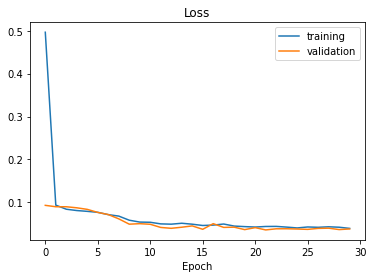

In [241]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [242]:
model.save('model.h5')

In [243]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>